# Experiments

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD
from utils import dict_concatenate

Let $x_1, \dots, x_n$ be the samples generated after $L$ steps of SVGD. The function `get_mse` computes three squared error values:
* SE$_1 = (E[X] - 1/n \sum_i x_i)^2$
* SE$_2 = (E[X^2] - 1/n \sum_i x_i^2)^2$
* SE$_3 = (E[\cos(\omega X)] - 1/n \sum_i \cos(\omega X))^2$

and averages them all over `m` random seeds to get three MSE values.

## Scan bandwidth values

In [2]:
n=100
d=1
stepsize = 0.01
L = 100
m = 30
grid_length = 30

In [3]:
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
bandwidth_grid = bandwidth_grid[:, np.newaxis]
for _ in range(d-1):
    bandwidth_grid = np.concatenate([bandwidth_grid, np.ones((grid_length, 1))], axis=1)
bandwidth_grid.shape

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

(30, 1)

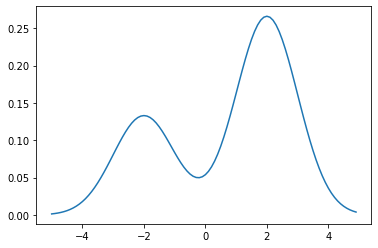

In [4]:
mpl.rcParams['figure.figsize'] = [6, 4]
from utils import log_gaussian_mixture

logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

grid = np.arange(-5, 5, 0.1)
vlogp = vmap(logp)
_ = plt.plot(grid, np.exp(vlogp(grid)))

In [5]:
svgd_fix = SVGD(logp=logp, n_iter=L, adaptive_kernel=False, get_bandwidth=None)

In [6]:
mse_dict = {
        "E[x]": [],
        "E[x^2]": [],
        "E[cos(wx)]": []
        }

In [32]:
mses_by_bandwidth = [] # list of dicts
for h in bandwidth_grid:
    for key in mse_dict.keys(): # make sure dictionary is empty
        mse_dict[key] = []
        
    # calculate mean squared error across m random seeds
    for seed in range(m):
        rkey = random.PRNGKey(seed)
        x0 = random.normal(rkey, shape=(n, d)) - 10

        xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=h)
        assert not np.any(np.isnan(xout))
        
        mse1 = (np.mean(xout, axis=0) - 2/3)**2
        mse2 = (np.mean(xout**2, axis=0) - 5)**2
        w = random.normal(rkey, (1,))
        mse3 = (np.mean(np.cos(w * xout), axis=0) - np.exp(-w**2 / 2))**2
        mses = [mse1, mse2, mse3]
        
        for i, key in enumerate(mse_dict.keys()):
            mse_dict[key].append(mses[i])

    for key in mse_dict.keys():
        mse_dict[key] = np.array(mse_dict[key]) # contains a list of m values per MSE type
        mse_dict[key] = np.mean(mse_dict[key], axis=0)
    
    mses_by_bandwidth.append(mse_dict.copy())

AssertionError: 

In [20]:
mses_by_bandwidth = dict_concatenate(mses_by_bandwidth)

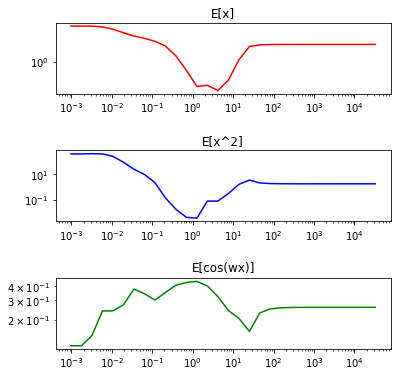

In [30]:
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
plt.subplots_adjust(hspace=0.8)
col = ["r", "b", "g"]
for i, key in enumerate(mses_by_bandwidth.keys()):
    plt.subplot(f"31{i+1}")
    plt.title(key)
    plt.plot(bandwidth_grid, mses_by_bandwidth[key], col[i])
    plt.xscale('log')
    plt.yscale('log')

In [15]:
stepsize = 0.01
L = int(1 / stepsize)
key = random.PRNGKey(0)
# kernel_param_grid_old = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful

# kernel_param_grid = random.uniform(key, shape=(25, d)) * 25 - 10
# kernel_param_grid = 2**kernel_param_grid
# kernel_param_grid = kernel_param_grid[kernel_param_grid[:, 0].argsort()]

kernel_param_grid = np.logspace(-10, 15, num=25, base=2)
kernel_param_grid = np.concatenate([kernel_param_grid[:, np.newaxis], np.ones((25, 1)), np.ones((25, 1))], axis=1)

m = 30


q1 = lambda key, n, d: random.normal(key, shape=(n,d)) - 10
# q2 = lambda key, n, d: random.normal(key, shape=(n,d)) * 2 + 10

In [24]:
mses1 = kernel_param_search(logp, n, d, stepsize, L, m, kernel_param_grid, q1)
mses2 = kernel_param_search(logp, n, d, stepsize, L, m, kernel_param_grid, q2)

For comparison, do the same estimates using an adaptive kernel parameter:

In [7]:
from svgd import kernel_param_update_rule
mses_adaptive1 = get_mse(logp, n, d, stepsize, L, m, q1, kernel_param = None, kernel_param_update_rule=kernel_param_update_rule)
mses_adaptive2 = get_mse(logp, n, d, stepsize, L, m, q2, kernel_param = None, kernel_param_update_rule=kernel_param_update_rule)

In [26]:
mses_adaptive1

{'E[x]': DeviceArray([18.289555, 18.255764, 18.180536], dtype=float32),
 'E[x^2]': DeviceArray([66.90888 , 66.380486, 65.39627 ], dtype=float32),
 'E[cos(wx)]': DeviceArray([0.7280354 , 0.73368657, 0.7257361 ], dtype=float32)}

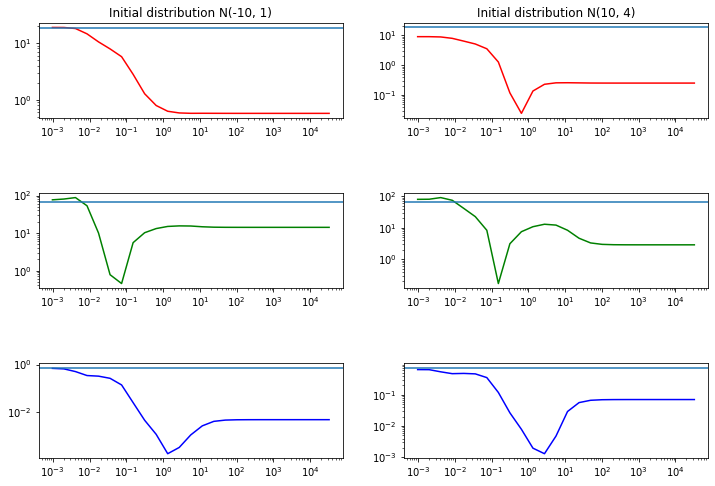

In [25]:
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
plt.subplots_adjust(hspace=0.8)
i = 0

### first q
mses = mses1
mses_adaptive = mses_adaptive1
plt.subplot(321)
plt.title("Initial distribution N(-10, 1)")
plt.plot(kernel_param_grid[:, i], mses['E[x]'][:, i], 'r')
plt.axhline(y=mses_adaptive["E[x]"][i])
plt.xscale('log')
plt.yscale('log')

plt.subplot(323)
plt.plot(kernel_param_grid[:, i], mses['E[x^2]'][:, i], 'g')
plt.axhline(y=mses_adaptive["E[x^2]"][i])
plt.xscale('log')
plt.yscale('log')


plt.subplot(325)
plt.plot(kernel_param_grid[:, i], mses['E[cos(wx)]'][:, i], 'b')
plt.axhline(y=mses_adaptive["E[cos(wx)]"][i])
plt.xscale('log')
plt.yscale('log')


####################
### second q
mses = mses2
plt.subplot(322)
plt.title("Initial distribution N(10, 4)")
plt.plot(kernel_param_grid[:, i], mses['E[x]'][:, i], 'r')
plt.axhline(y=mses_adaptive["E[x]"][i])
plt.xscale('log')
plt.yscale('log')

plt.subplot(324)
plt.plot(kernel_param_grid[:, i], mses['E[x^2]'][:, i], 'g')
plt.axhline(y=mses_adaptive["E[x^2]"][i])
plt.xscale('log')
plt.yscale('log')


plt.subplot(326)
plt.plot(kernel_param_grid[:, i], mses['E[cos(wx)]'][:, i], 'b')
plt.axhline(y=mses_adaptive["E[cos(wx)]"][i])
plt.xscale('log')
plt.yscale('log')

Figure: Mean squared error (y-axis) vs. kernel parameter values (x-axis). The horizontal lines indicate the MSE obtained when computing the estimate using an adaptive kernel.
* Red: MSE when estimating $E[X]$.
* Green: MSE when estimating $E[X^2]$.
* Blue: MSE when estimating $E[\cos(\omega X)]$.

Columns:
* Left column: results for initial distribution $q_0 \sim \mathcal N(-10, 1)$.
* Right column: results for initial distribution $q_0 \sim \mathcal N(10, 4)$.

## Search parameters of initial distribution

In [12]:
default_q = lambda key, n, d: random.normal(key, shape=(n,d)) - 10
def q_param_search(logp, kernel_param, n, d, stepsize, L, param_grid, m=20, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for param in param_grid:
        q = lambda key, n, d: random.normal(key, shape=(n,d)) * param[1] + param[0]
        mse1, mse2, mse3 = list(get_mse(logp, n, d, stepsize, L, m, q, kernel_param, kernel_param_update_rule).values())

        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
        
        mse1 = np.array(mse1)
        mse2 = np.array(mse2)
        mse3 = np.array(mse3)

    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses


In [13]:
n = 100
stepsize = 0.01
L = int(1 / stepsize)
stdev = 1
param_grid = [(mean, stdev) for mean in np.arange(-20, 20, 1)]
m = 30
kernel_param = 5

In [14]:
from svgd import kernel_param_update_rule

mses3 = q_param_search(logp, kernel_param, n, d, stepsize, L, param_grid, m)
mses4 = q_param_search(logp, None, n, d, stepsize, L, param_grid, m, kernel_param_update_rule)

param_grid = [param[0] for param in param_grid] # just wanna plot wrt the means

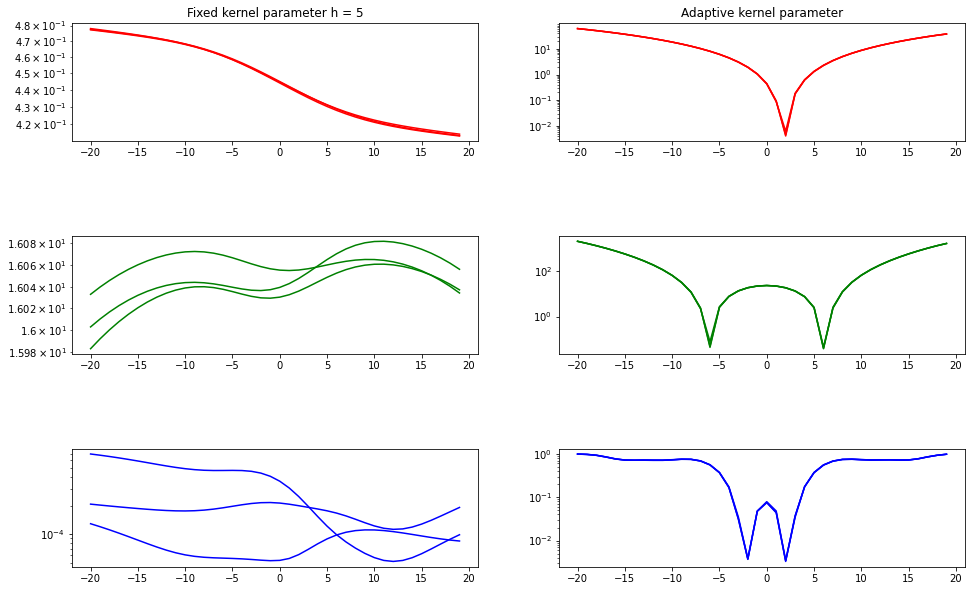

In [23]:
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
plt.subplots_adjust(hspace=0.8)

### fixed kernel parameter
mses = mses3
plt.subplot(321)
plt.title(f"Fixed kernel parameter h = {kernel_param}")
plt.plot(param_grid, mses['E[x]'], 'r')
plt.yscale('log')

plt.subplot(323)
plt.plot(param_grid, mses['E[x^2]'], 'g')
plt.yscale('log')

plt.subplot(325)
plt.plot(param_grid, mses['E[cos(wx)]'], 'b')
plt.yscale('log')

############################
### adaptive kernel parameter
mses = mses4
plt.subplot(322)
plt.title("Adaptive kernel parameter")
plt.plot(param_grid, mses['E[x]'], 'r')
plt.yscale('log')

plt.subplot(324)
plt.plot(param_grid, mses['E[x^2]'], 'g')
plt.yscale('log')

plt.subplot(326)
plt.plot(param_grid, mses['E[cos(wx)]'], 'b')
plt.yscale('log')